# Exercise 2

You are allowed to use the folowing functions and classes from `torch.nn`: `nn.Module`, `nn.Parameter`, `nn.ConvXd` (X ={1,2,3}), `nn.Linear`.

In [112]:
import numpy as np
from matplotlib import pyplot as plt
import torch

# y,x,h,w
gt_boxes = np.array(
    [
        [2.36, 6.77, 1.25, 2.41],
        [1.51, 2.48, 3.0, 1.42],
        [6.85, 3.75, 1.91, 3.99],
        [2.15, 4.98, 1.18, 1.47],
    ]
)

# y,x,h,w,score
pred_boxes = np.array(
    [
        [2.31, 6.48, 1.25, 2.33, 0.52],
        [1.51, 2.65, 2.89, 1.28, 0.39],
        [6.84, 3.87, 1.8, 4.02, 0.72],
        [2.0, 4.8, 1.48, 1.2, 0.86],
    ]
)

### 1. Loss Functions

Consider the following bounding box predictions `pred_boxes` and ground truths `gt_boxes`.

1. Implement a function to compute the pairwise IoU between two boxes. Visualize the IoUs between `gt_boxes` and `pred_boxes`.
2. Implement the focal loss.

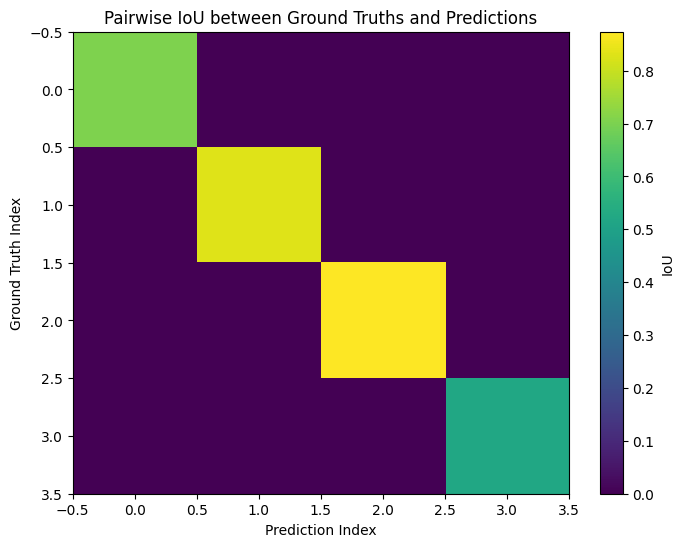

In [113]:
def compute_iou(boxA, boxB):
    # Assumes x1,y1 to be the bottom left corner of the box
    Ax1, Ay1, Ax2, Ay2 = boxA[:4]
    Bx1, By1, Bx2, By2 = boxB[:4]

    intersection = max(0, min(Ax2, Bx2) - max(Ax1, Bx1)) * max(
        0, min(Ay2, By2) - max(Ay1, By1)
    )
    union = (Ay2 - Ay1) * (Ax2 - Ax1) + (By2 - By1) * (Bx2 - Bx1) - intersection

    return intersection / union


# Compute pairwise IoU
ious = np.zeros((gt_boxes.shape[0], gt_boxes.shape[1]))


for i, gt in enumerate(gt_boxes):
    for j, pred in enumerate(pred_boxes[:, :4]):  # Only use (y, x, h, w)
        a0 = gt[1]
        a1 = gt[0]
        a2 = gt[1] + gt[3]
        a3 = gt[0] + gt[2]
        A = torch.tensor([a0, a1, a2, a3])
        b0 = pred[1]
        b1 = pred[0]
        b2 = pred[1] + pred[3]
        b3 = pred[0] + pred[2]
        B = torch.tensor([b0, b1, b2, b3])
        ious[i, j] = compute_iou(A, B)

# Visualize IoUs as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(ious, cmap="viridis", aspect="auto")
plt.colorbar(label="IoU")
plt.title("Pairwise IoU between Ground Truths and Predictions")
plt.xlabel("Prediction Index")
plt.ylabel("Ground Truth Index")
plt.show()

In [114]:
def focal_loss(pred_probs, true_labels, alpha=0.25, gamma=2.0):
    """
    Compute the focal loss for binary classification using PyTorch operations.

    Args:
        pred_probs (torch.Tensor): Predicted probabilities (N, C)
        true_labels (torch.Tensor): True binary labels (N, C)
        alpha (float): Balancing factor, default is 0.25
        gamma (float): Focusing parameter, default is 2.0

    Returns:
        torch.Tensor: Focal loss
    """
    # Reshape inputs if needed
    pred_probs = pred_probs.reshape(-1, pred_probs.shape[-1])  # Shape: (N, C)
    true_labels = true_labels.reshape(-1, true_labels.shape[-1])  # Shape: (N, C)

    pt = torch.where(true_labels == 1, pred_probs, 1 - pred_probs)  # p_t

    # Add small epsilon to avoid log(0)
    loss = -alpha * ((1 - pt) ** gamma) * torch.log(pt + 1e-9)

    # Sum the loss
    return torch.sum(loss)

In [115]:
# Test the focal loss function
x = torch.Tensor([0.2, 0.4, 0.3, 0.1]).unsqueeze_(0)
y = torch.Tensor([0, 0, 0, 1]).unsqueeze_(0)
print(x.shape)
print(y.shape)
print(focal_loss(x, y))

torch.Size([1, 4])
torch.Size([1, 4])
tensor(0.4970)


### 2. Average Prediction

Implement a function that computes the average precision. Use the point interpolation method (see updated lecture slides).
Compute the AP for `scored_detections`.


Average Precision: 0.7499


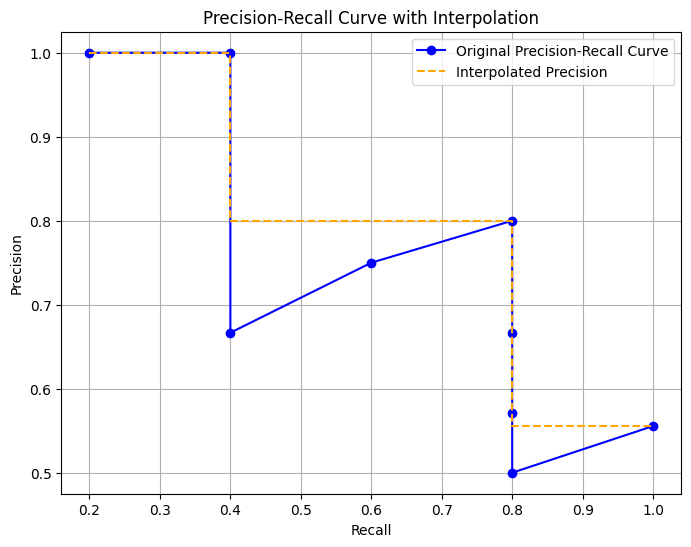

In [116]:
scored_detections = [
    [78.4, True],
    [72.4, True],
    [65.1, False],
    [63.6, True],
    [63.4, True],
    [57.6, False],
    [54.6, False],
    [23.2, False],
    [12.2, True],
]


def average_precision(scored_detections, recall_points=np.linspace(0, 1, 11)):
    # Extract true positives (TP) and false positives (FP)
    tp = np.cumsum([d[1] for d in scored_detections])
    fp = np.cumsum([not d[1] for d in scored_detections])
    total_positives = sum([d[1] for d in scored_detections])

    # Compute precision and recall
    precision = tp / (tp + fp)
    recall = tp / total_positives

    # Interpolate precision at each recall point
    interpolated_precision = precision.copy()
    for i in range(len(precision) - 2, -1, -1):  # Start from second-to-last element
        interpolated_precision[i] = max(
            interpolated_precision[i], interpolated_precision[i + 1]
        )

    # Compute AP as the mean of interpolated precisions
    average_precision = np.mean(interpolated_precision)
    return precision, recall, interpolated_precision, average_precision


precision, recall, interpolated_precision, average = average_precision(
    scored_detections
)

# Compute the average precision
print(f"Average Precision: {average:.4f}")

# Plot original PR curve and interpolated PR curve
plt.figure(figsize=(8, 6))
plt.plot(
    recall, precision, label="Original Precision-Recall Curve", marker="o", color="blue"
)
plt.step(
    recall,
    interpolated_precision,
    where="post",
    label="Interpolated Precision",
    color="orange",
    linestyle="--",
)
plt.title("Precision-Recall Curve with Interpolation")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

### 3. Implement the Hungarian Loss

1. Implement a DETR detection head with 20 queries that uses the `features` tensor. Use your self-attention implementation from exercise 1 and adapt it for cross-attention.
2. Implement the hungarian loss. For simplicity, use the L1 loss as the distance (you might need to use the sigmoid function on your activations).  
   Use the Hungarian algorithm implementation from scipy.  
3. Train the cross-attention layer to match the 10 target boxes.  
**Hint:** Initializations are crucial, so check your initial predictions.


In [117]:
from scipy.optimize import linear_sum_assignment
from torchvision.ops import box_convert
from torchvision.utils import draw_bounding_boxes

query_tokens = torch.randn(20, 256)  # these go to query
feature_tokens = torch.rand(7, 7, 256)  # these go to keys and values

# box_convert(boxes, 'cxcywh', 'xyxy')  # a useful function

### 1. DETR detection head with cross attention

In [118]:
import math


def calc_attention(q: torch.tensor, k: torch.tensor, v: torch.tensor):
    n, d = q.shape
    # Formula from the slides
    return torch.softmax(((q @ k.mT) / math.sqrt(d)), dim=0) @ v

In [119]:
def cross_attention_layer(query_tokens: torch.Tensor, feature_tokens: torch.Tensor):
    """
    Perform cross-attention between query and feature tokens

    Args:
    - query_tokens (Tensor): Queries of shape (num_queries, query_dim)
    - feature_tokens (Tensor): Features of shape (num_features, feature_dim)

    Returns:
    - Tensor of attended query tokens
    """

    # Reshape feature tokens if they are 2D spatial
    if len(feature_tokens.shape) == 3:
        h, w, feature_dim = feature_tokens.shape
        feature_tokens = feature_tokens.view(h * w, feature_dim)

    # Perform cross-attention
    attended_queries = calc_attention(
        q=query_tokens, k=feature_tokens, v=feature_tokens  # Queries  # Keys  # Values
    )

    return attended_queries

In [120]:
import torch.nn as nn


class DETRDetectionHead(nn.Module):
    def __init__(self, query_tokens, num_classes=10):
        super().__init__()
        self.query_tokens = nn.Parameter(query_tokens.clone().detach())
        num_queries, feat_dim = query_tokens.shape
        self.bbox_head = nn.Linear(feat_dim, 4)  # (x, y, width, height)

    def forward(self, feature_tokens):
        # Perform cross-attention
        attended_queries = cross_attention_layer(self.query_tokens, feature_tokens)

        # Predict classes and bounding boxes
        bbox_predictions = torch.sigmoid(self.bbox_head(attended_queries))
        return bbox_predictions

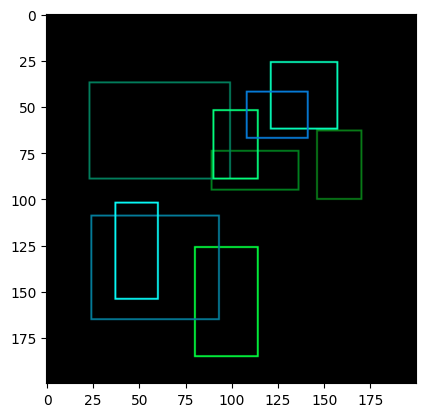

In [121]:
c = 0.2 + torch.rand(10, 2) * 0.6
s = 0.1 + torch.rand(10, 2) * 0.3
targets = torch.cat([c, s], dim=1)
plt.imshow(
    draw_bounding_boxes(
        torch.zeros(3, 200, 200), 200 * box_convert(targets, "cxcywh", "xyxy")
    ).permute(1, 2, 0)
)

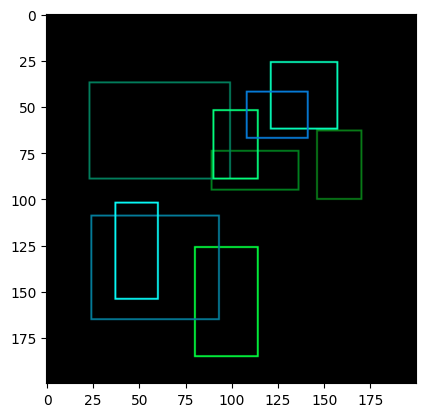

In [122]:
import torchvision

plt.imshow(
    torchvision.utils.draw_bounding_boxes(
        torch.zeros(3, 200, 200), 200 * box_convert(targets, "cxcywh", "xyxy")
    ).permute(1, 2, 0)
)

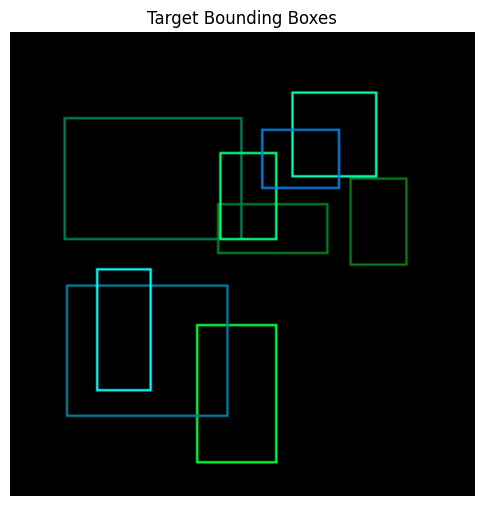

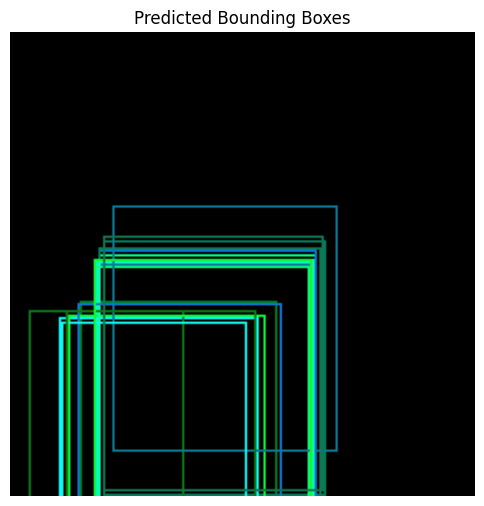

Bbox Predictions Shape: torch.Size([20, 4])
Target Bounding Boxes Shape: torch.Size([10, 4])


In [123]:
def visualize_detections(targets, title):
    plt.figure(figsize=(10, 5))

    # Convert to xyxy format and scale
    scaled_boxes = 200 * box_convert(targets, "cxcywh", "xyxy")

    # First subplot
    plt.subplot(1, 2, 1)
    plt.imshow(
        torchvision.utils.draw_bounding_boxes(
            torch.zeros(3, 200, 200), scaled_boxes
        ).permute(1, 2, 0)
    )
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


# Initialize DETR-style detection head
detection_head = DETRDetectionHead(query_tokens, num_classes=targets.shape[0])

# Generate predictions
outputs = detection_head(feature_tokens)

# Visualize targets
visualize_detections(targets, title="Target Bounding Boxes")
visualize_detections(outputs, title="Predicted Bounding Boxes")

# Print some details
print("Bbox Predictions Shape:", outputs.shape)
print("Target Bounding Boxes Shape:", targets.shape)

### 2. Hungarian loss

In [124]:
def hungarian_loss(pred, target):
    # Compute pairwise distance matrix (L1 distance)
    cost_matrix = torch.cdist(pred, target, p=1)

    # Add colums with max values to make the matrix square
    max_value = cost_matrix.max()
    cost_matrix = torch.cat(
        [cost_matrix, max_value * torch.ones(cost_matrix.shape[0], 1)], dim=1
    )

    # Apply Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(cost_matrix.detach().cpu().numpy())

    # Compute loss as the sum of matched distances
    loss = cost_matrix[row_ind, col_ind].sum()
    return loss

### 3. Train detection head on 10 target boxes

Epoch 5000 - Loss: 1.2997997999191284
Epoch 10000 - Loss: 1.4414923191070557
Epoch 15000 - Loss: 1.2510777711868286
Epoch 20000 - Loss: 1.330997347831726
Epoch 25000 - Loss: 1.3549582958221436
Epoch 30000 - Loss: 1.3490016460418701
Epoch 35000 - Loss: 1.2308508157730103
Epoch 40000 - Loss: 1.3079514503479004
Epoch 45000 - Loss: 1.2408537864685059
Epoch 50000 - Loss: 1.249222755432129


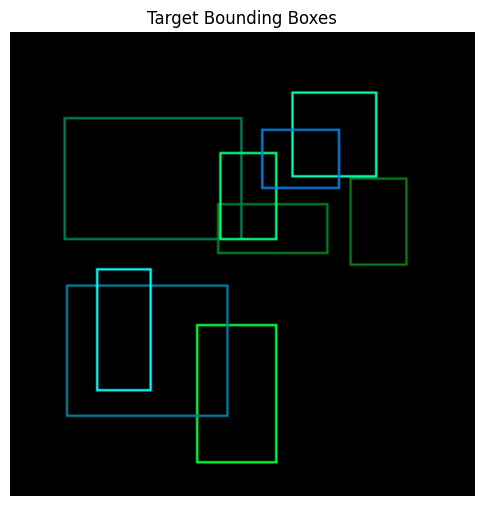

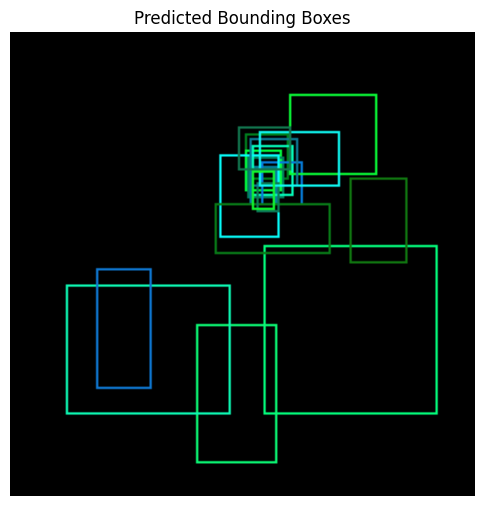

In [125]:
detr = DETRDetectionHead(query_tokens, num_classes=targets.shape[0])
optimizer = torch.optim.Adam(detr.parameters(), lr=1e-3)
criterion = hungarian_loss
for epoch in range(50000):
    # Forward pass
    pred = detr(feature_tokens)
    loss = criterion(pred, targets)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 5000 == 0:
        print(f"Epoch {epoch + 1} - Loss: {loss.item()}")

visualize_detections(targets, title="Target Bounding Boxes")
visualize_detections(pred, title="Predicted Bounding Boxes")

### 4. Object Detector Implementation and Training

#### Detector Implementation
Implement one of the following object detectors (or a combination of them): FCOS, CenterNet or RetinaNet.  
FCOS: https://openaccess.thecvf.com/content_ICCV_2019/papers/Tian_FCOS_Fully_Convolutional_One-Stage_Object_Detection_ICCV_2019_paper.pdf    
CenterNet: https://arxiv.org/pdf/1904.08189   
RetinaNet: https://arxiv.org/pdf/1708.02002v2.pdf  
Use a ResNet18 as a backbone. Don't forget to implement the FPN. You are free to use all of PyTorch (including `torch.nn`) and torchvision.

#### Detector Training
Train the detector on MS COCO selection.   
You can download the images here: http://images.cocodataset.org/zips/val2017.zip   
Upload your predictions on the test set to StudIP in the format defined below (`ex2_groupX_predictions.json`).  
**Note:** This is a fairly small training dataset of only 2000 images for detection, so don't expect state-of-the-art performance.

In [126]:
from torchvision.models import resnet18, ResNet18_Weights
from torch import nn

resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)


class ResNetBackbone(nn.Module):
    def __init__(self, resnet):
        super().__init__()
        # Store individual layers for stage1
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1

        # Remaining stages
        self.stage2 = resnet.layer2
        self.stage3 = resnet.layer3
        self.stage4 = resnet.layer4

    def sequential_forward(self, x, layers):
        for layer in layers:
            x = layer(x)
        return x

    def forward_stage1(self, x):
        stage1_layers = [self.conv1, self.bn1, self.relu, self.maxpool, self.layer1]
        return self.sequential_forward(x, stage1_layers)

    def forward(self, x):
        c2 = self.forward_stage1(x)
        c3 = self.stage2(c2)
        c4 = self.stage3(c3)
        c5 = self.stage4(c4)
        return c5

    def get_features(self, x):
        c2 = self.forward_stage1(x)
        c3 = self.stage2(c2)
        c4 = self.stage3(c3)
        c5 = self.stage4(c4)
        return c2, c3, c4, c5


backbone = ResNetBackbone(resnet)

in_channels = [64, 128, 256, 512]

In [127]:
# Nearest neighbor upsampling
def upsample(x, scale_factor):
    return x.repeat_interleave(scale_factor, dim=-2).repeat_interleave(
        scale_factor, dim=-1
    )


# Nearest neighbor downsampling
def downsample(x, scale_factor):
    height = len(x)
    width = len(x[0])

    # Create new downsampled map
    return [
        [x[i][j] for j in range(0, width, scale_factor)]
        for i in range(0, height, scale_factor)
    ]


# Test the upsample and downsample functions
x = torch.randn(3, 224, 224)
x_upsampled = upsample(x, 2)
y = torch.randn(224, 224, 4)
y_downsampled = downsample(y, 2)
print(
    x.shape,
    x_upsampled.shape,
    len(y_downsampled),
    len(y_downsampled[0]),
    len(y_downsampled[0][0]),
)

torch.Size([3, 224, 224]) torch.Size([3, 448, 448]) 112 112 4


In [128]:
class FPN(nn.Module):
    def __init__(self, in_channels, out_channels=256):
        super().__init__()
        # Lateral convolutions
        # I am not sure if they should map to out_channels because it does not matter since they will be remapped to out_channels in the output convolutions anyway
        # I could not find anything about this in the paper tough
        self.lateral_conv1 = nn.Conv2d(in_channels[1], out_channels, kernel_size=1)
        self.lateral_conv2 = nn.Conv2d(in_channels[2], out_channels, kernel_size=1)
        self.lateral_conv3 = nn.Conv2d(in_channels[3], out_channels, kernel_size=1)

        # Output convolutions
        self.output_conv1 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, padding=1
        )
        self.output_conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, padding=1
        )
        self.output_conv3 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, padding=1
        )
        self.ouptut_conv4 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, padding=1, stride=2
        )

    def forward(self, features):
        c2, c3, c4, c5 = features
        # Top-down pathway
        p5 = self.output_conv3(self.lateral_conv3(c5))
        p4 = self.output_conv2(self.lateral_conv2(c4) + upsample(p5, 2))
        p3 = self.output_conv1(self.lateral_conv1(c3) + upsample(p4, 2))
        p6 = self.ouptut_conv4(p5)
        p7 = self.ouptut_conv4(p6)

        return [p3, p4, p5, p6, p7]

In [129]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CustomReLU(nn.Module):
    def forward(self, x):
        return torch.maximum(x, torch.zeros_like(x))


class CustomGroupNorm(nn.Module):
    def __init__(self, num_groups, num_channels, eps=1e-5):
        super().__init__()
        self.num_groups = num_groups
        self.num_channels = num_channels
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))

    def forward(self, x):
        N, C, H, W = x.shape
        x = x.reshape(N, self.num_groups, -1)

        # Calculate mean and variance
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, keepdim=True, unbiased=False)

        # Normalize
        x = (x - mean) / torch.sqrt(var + self.eps)
        x = x.reshape(N, C, H, W)

        # Apply weight and bias
        return x * self.weight.view(1, -1, 1, 1) + self.bias.view(1, -1, 1, 1)


class CustomSequential:
    def __init__(self, *layers):
        self.layers = list(layers)

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class FCOSHead(nn.Module):
    def __init__(self, in_channels, num_classes, num_convs=4):
        super().__init__()
        self.si = nn.Parameter(torch.tensor(0.1))

        # Classification branch
        cls_tower = []
        for _ in range(num_convs):
            cls_tower.append(
                nn.Conv2d(
                    in_channels, in_channels, kernel_size=3, padding=1, bias=False
                )
            )
            cls_tower.append(CustomGroupNorm(32, in_channels))
            cls_tower.append(CustomReLU())
        self.cls_tower = CustomSequential(*cls_tower)

        # Final classification layer
        self.cls_pred = nn.Conv2d(in_channels, num_classes, kernel_size=3, padding=1)

        # Box regression branch
        bbox_tower = []
        for _ in range(num_convs):
            bbox_tower.append(
                nn.Conv2d(
                    in_channels, in_channels, kernel_size=3, padding=1, bias=False
                )
            )
            bbox_tower.append(CustomGroupNorm(32, in_channels))
            bbox_tower.append(CustomReLU())
        self.bbox_tower = CustomSequential(*bbox_tower)

        # Final bbox regression layer
        self.bbox_pred = nn.Conv2d(in_channels, 4, kernel_size=3, padding=1)

        # Centerness branch
        self.centerness = nn.Conv2d(in_channels, 1, kernel_size=3, padding=1)

    def forward(self, x):
        cls_tower = self.cls_tower(x)
        bbox_tower = self.bbox_tower(x)

        # Make probability distribution out of classification tower
        cls_pred = torch.softmax(self.cls_pred(cls_tower), dim=1)

        # Make positive-only bbox prediction
        bbox_pred = torch.exp(self.bbox_pred(bbox_tower))

        # Make centerness range from 0 to 1
        centerness = torch.sigmoid(self.centerness(cls_tower))

        return cls_pred, bbox_pred, centerness

In [130]:
class FCOS(nn.Module):
    def __init__(self, backbone, fpn, num_classes):
        super().__init__()
        self.backbone = backbone
        self.fpn = fpn
        self.head = FCOSHead(in_channels=256, num_classes=num_classes)

    def forward(self, x):
        # Get backbone features
        c2, c3, c4, c5 = backbone.get_features(x)
        features = [c2, c3, c4, c5]

        # Get FPN features
        fpn_features = self.fpn(features)

        # Apply head to each FPN level
        cls_preds, bbox_preds, centerness_preds = [], [], []
        for index, feature in enumerate(fpn_features):
            cls_pred, bbox_pred, centerness_pred = self.head(feature)
            cls_preds.append(cls_pred.permute(0, 3, 2, 1).squeeze(0))
            # unsqueeze bbox_pred to add a dimension (using * 1)
            # This is just so my functions work, it does not hold any real value
            bbox_preds.append((bbox_pred * 1).permute(0, 3, 2, 1).squeeze(0))
            centerness_preds.append(centerness_pred.permute(0, 3, 2, 1).squeeze(0))

        return {
            "cls_preds": cls_preds,
            "bbox_preds": bbox_preds,
            "centerness_preds": centerness_preds,
        }

In [131]:
import torch
from torchvision.transforms import v2
from torchvision.datasets import CocoDetection

subset_name = "val2017"

img_size = 224

# Define the image transformations
transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize(img_size, antialias=True),
        v2.CenterCrop(img_size),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

coco = CocoDetection(subset_name, annFile=f"./cocofix.json", transforms=transforms)
coco_test = CocoDetection(
    subset_name,
    annFile=f"./instances_course_test_no_annotations.json",
    transforms=transforms,
)
len(coco), len(coco_test)

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


(2000, 361)

In [132]:
transformed_img, transformed_target = coco[0]

print("Transformed Image Size:", transformed_img.shape)
print("Transformed Bounding Boxes:", [obj["bbox"] for obj in transformed_target])

Transformed Image Size: torch.Size([3, 224, 224])
Transformed Bounding Boxes: [[48.63072463768118, 63.33217391304348, 28.18782608695652, 42.84753623188406], [175.06318840579712, 89.27536231884058, 3.974492753623188, 16.505507246376812], [173.82492753623188, 117.31942028985507, 3.719420289855072, 15.735652173913042], [169.85971014492753, 138.0313043478261, 2.467246376811594, 18.402318840579706], [198.23768115942028, 88.58898550724639, 5.634782608695652, 17.057391304347824], [189.68579710144928, 92.44289855072465, 3.4689855072463764, 13.008695652173913], [77.13391304347827, 106.87536231884057, 48.56579710144927, 40.66782608695652], [124.68405797101451, 98.4904347826087, 38.26550724637681, 66.31884057971014], [177.34956521739133, 88.8904347826087, 13.602318840579708, 16.714202898550724], [208.00927536231882, 115.27884057971015, 11.315942028985505, 18.75014492753623], [204.47072463768114, 89.70666666666668, 1.892173913043478, 15.856231884057967], [194.26782608695652, 25.706666666666678, 1.

In [133]:
len(coco), len(coco[0]), coco[0][0].shape, len(coco[0][1]), coco[0][1][1]

(2000,
 2,
 torch.Size([3, 224, 224]),
 17,
 {'segmentation': [[457.3,
    224.79,
    455.98,
    192.5,
    464.55,
    196.46,
    461.25,
    228.09]],
  'area': 203.6632999999997,
  'iscrowd': 0,
  'image_id': 632,
  'bbox': [175.06318840579712,
   89.27536231884058,
   3.974492753623188,
   16.505507246376812],
  'category_id': 84,
  'id': 1657298,
  'category_name': 'book'})

In [134]:
coco[0][1][0].keys()

dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id', 'category_name'])

Bbox distances: [26, 64, 12, 2]
Class one-hot encoding: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Centerness value: 0.12009611535056755


(224, 224)

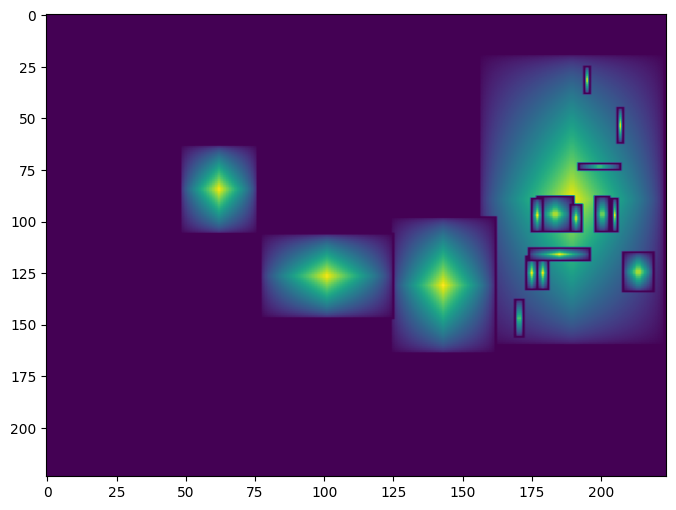

In [ ]:
import numpy as np


# Convert to the format needed for predictions as described in the paper
def preprocess_target(image_targets, num_classes, image_size=224):
    """
    Create FCOS target map where each pixel contains a dictionary

    Args:
        image_targets: List of dicts containing 'bbox' [x,y,w,h] and 'category_id'
        num_classes: Number of classes for one-hot encoding
        image_size: Size of the square target map

    Returns:
        target_map: 2D list of dictionaries, each containing:
                   'bbox': [l,t,r,b] distances
                   'class_id': one-hot encoded list of length num_classes
                   'centerness': centerness value
    """
    # Initialize target map with empty dictionaries
    target_map = [
        [
            {"bbox": [0, 0, 0, 0], "class_id": [0] * num_classes, "centerness": 0}
            for _ in range(image_size)
        ]
        for _ in range(image_size)
    ]

    # For each pixel, we'll store the box with smallest area if multiple boxes overlap
    min_area_map = np.full((image_size, image_size), float("inf"))

    for target in image_targets:
        # Extract bbox coordinates
        x, y, w, h = target["bbox"]
        category_id = target["category_id"]

        # Convert to x1,y1,x2,y2 format
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + w), int(y + h)

        # Clip to image boundaries
        x1, y1, x2, y2 = (
            max(0, min(image_size - 1, x1)),
            max(0, min(image_size - 1, y1)),
            max(0, min(image_size - 1, x2)),
            max(0, min(image_size - 1, y2)),
        )

        # For each pixel inside the box
        for y_i in range(y1, y2 + 1):
            for x_i in range(x1, x2 + 1):
                # Calculate l,t,r,b distances
                left = x_i - x1
                top = y2 - y_i
                right = x2 - x_i
                bottom = y_i - y1

                # Get min area of the box
                min_area = target["area"]

                # Only update if the area is smaller (method used in the paper)
                if min_area < min_area_map[y_i, x_i]:
                    min_area_map[y_i, x_i] = min_area

                    # Calculate centerness
                    centerness = np.sqrt(
                        (min(left, right) / (max(left, right) + 1e-9))
                        * (min(top, bottom) / (max(top, bottom) + 1e-9))
                    )

                    # Update dictionary at this pixel
                    target_map[y_i][x_i] = {
                        "bbox": [left, top, right, bottom],
                        "class_id": [
                            1 if i == category_id else 0 for i in range(num_classes)
                        ],
                        "centerness": centerness,
                    }

    return target_map


# Example usage:
sample_target = coco[0][1]
target_map = preprocess_target(sample_target, num_classes=91)

# Example of accessing a pixel's data:
pixel_data = target_map[100][150]  # Get data for pixel at (100,150)
print("Bbox distances:", pixel_data["bbox"])
print("Class one-hot encoding:", pixel_data["class_id"])
print("Centerness value:", pixel_data["centerness"])

# create a heatmap of the centerness values for testing
centerness_map = np.array(
    [[pixel["centerness"] for pixel in row] for row in target_map]
)
plt.figure(figsize=(8, 6))
plt.imshow(centerness_map, cmap="viridis", aspect="auto")
len(target_map), len(target_map[0])

Number of feature levels: 5
Feature level shapes: [torch.Size([28, 28, 91]), torch.Size([14, 14, 91]), torch.Size([7, 7, 91]), torch.Size([4, 4, 91]), torch.Size([2, 2, 91])]


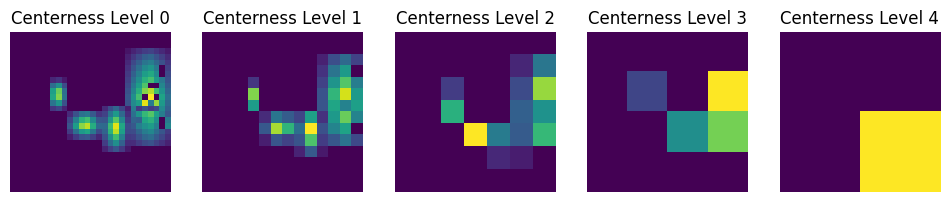

In [ ]:
from torch.nn import functional as F
import copy


def scale_target(target_map, feature_strides=[8, 16, 32, 64, 128]):
    """
    Convert a 224x224 target map into multiple feature level targets for FCOS.
    Following FCOS paper's level assignment using max regression distance.

    Args:
        target_map: 2D list of shape [224][224] where each entry is a dict containing:
            - 'class_id': One-hot encoded tensor for class labels
            - 'bbox': tensor or list [l,t,r,b] distances to object boundaries
            - 'centerness': float with centerness value
        feature_strides: list of strides for each feature level
    """
    H = W = 224  # Original dimensions
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Get number of classes from the one-hot encoding
    num_classes = (
        len(target_map[0][0]["class_id"])
        if target_map[0][0] is not None
        else next(t["class_id"].shape[0] for t in sum(target_map, []) if t is not None)
    )

    # Initialize full resolution tensors
    cls_map = torch.zeros(H, W, num_classes, device=device)
    bbox_map = torch.zeros(H, W, 4, device=device)
    centerness_map = torch.zeros(H, W, device=device)

    # Fill the tensors from the 2D target map
    for y in range(H):
        for x in range(W):
            target_dict = target_map[y][x]
            # Only take foreground pixels
            if target_dict["centerness"] > 0:
                cls_map[y, x] = torch.tensor(target_dict["class_id"], device=device)
                bbox_map[y, x] = torch.tensor(target_dict["bbox"], device=device)
                centerness_map[y, x] = target_dict["centerness"]

    # Distance thresholds for each level as per the paper
    # m2, m3, m4, m5, m6, m7 = 0, 64, 128, 256, 512, ∞
    m_thresholds = {
        8: (0, 64),  # m2 to m3
        16: (64, 128),  # m3 to m4
        32: (128, 256),  # m4 to m5
        64: (256, 512),  # m5 to m6
        128: (512, float("inf")),  # m6 to m7
    }

    multi_level_targets = []

    for stride in feature_strides:
        # Calculate feature map size for this level
        feat_h, feat_w = math.ceil(H / stride), math.ceil(W / stride)

        # Initialize empty targets for this level
        level_targets = {
            "class_id": torch.zeros(feat_h, feat_w, num_classes, device=device),
            "bbox": torch.zeros(feat_h, feat_w, 4, device=device),
            "centerness": torch.zeros(feat_h, feat_w, device=device),
        }

        # Scale down the original tensors to this level's size
        downsampled_map = downsample(target_map, stride)
        small_map = copy.deepcopy(downsampled_map)

        for y in range(feat_h):
            for x in range(feat_w):
                level_targets["bbox"][y][x] = torch.Tensor(
                    [i / stride for i in small_map[y][x]["bbox"]]
                )
                level_targets["class_id"][y][x] = torch.tensor(
                    small_map[y][x]["class_id"], device=device
                )
                level_targets["centerness"][y][x] = small_map[y][x]["centerness"]

        multi_level_targets.append(level_targets)

    return multi_level_targets


# Example usage:
scaled_map = [scale_target(target_map)]
print("Number of feature levels:", len(scaled_map[0]))
print("Feature level shapes:", [t["class_id"].shape for t in scaled_map[0]])
# plot center-ness heatmap for each level
plt.figure(figsize=(12, 6))
for i, level_target in enumerate(scaled_map[0]):
    plt.subplot(1, len(scaled_map[0]), i + 1)
    plt.imshow(level_target["centerness"], cmap="viridis")
    plt.title(f"Centerness Level {i}")
    plt.axis("off")

In [138]:
# Try the model
model = FPN(in_channels)
model.eval()
x = coco[0][0].unsqueeze(0)
with torch.no_grad():
    c2, c3, c4, c5 = backbone.get_features(x)

    features = [c2, c3, c4, c5]
    print([f.shape for f in features])
    pyramid_layers = model(features)
    print([p.shape for p in pyramid_layers])

[torch.Size([1, 64, 56, 56]), torch.Size([1, 128, 28, 28]), torch.Size([1, 256, 14, 14]), torch.Size([1, 512, 7, 7])]
[torch.Size([1, 256, 28, 28]), torch.Size([1, 256, 14, 14]), torch.Size([1, 256, 7, 7]), torch.Size([1, 256, 4, 4]), torch.Size([1, 256, 2, 2])]


In [139]:
# More testing
backbone = ResNetBackbone(resnet)
fpn = FPN(in_channels)
num_classes = 91
model = FCOS(backbone, fpn, num_classes)
x = coco[0][0].unsqueeze(0)
with torch.no_grad():
    outputs = model(x)
    outputs["cls_preds"] = [outputs["cls_preds"]]
    outputs["bbox_preds"] = [outputs["bbox_preds"]]
    outputs["centerness_preds"] = [outputs["centerness_preds"]]
    print((outputs).keys())
    print(
        len(outputs["cls_preds"][0]),
        len(outputs["bbox_preds"][0]),
        len(outputs["centerness_preds"][0]),
        outputs["cls_preds"][0][0].shape,
        outputs["bbox_preds"][0][0].shape,
        outputs["centerness_preds"][0][0].shape,
    )
    print([o.shape for o in outputs["cls_preds"][0]])

dict_keys(['cls_preds', 'bbox_preds', 'centerness_preds'])
5 5 5 torch.Size([28, 28, 91]) torch.Size([28, 28, 4]) torch.Size([28, 28, 1])
[torch.Size([28, 28, 91]), torch.Size([14, 14, 91]), torch.Size([7, 7, 91]), torch.Size([4, 4, 91]), torch.Size([2, 2, 91])]


In [140]:
def ltrb_to_xyxy(output_bbox):
    """
    Convert ltrb format to xyxy format.

    Args:
        output_bbox (torch.Tensor): Shape (H, W, 4) with left, top, right, bottom distances.

    Returns:
        output_bbox (torch.Tensor): Shape (H, W, 4) with x1, y1, x2, y2 coordinates.
    """
    for y in range(len(output_bbox)):
        for x in range(len(output_bbox[0])):
            box = output_bbox[y, x]
            x1 = x - box[0]
            y1 = y - box[3]
            x2 = x + box[2]
            y2 = y + box[1]
            output_bbox[y, x] = torch.Tensor([x1, y1, x2, y2])
    return output_bbox

In [141]:
# Test loss calculation (variable names are terrible, will be improved in actual calculation later)
batch_losses = []
# batch is the latent dimension that is just needed for my functions to work
for batch in range(len(outputs["cls_preds"])):
    cls_loss = 0
    reg_loss = 0
    centerness_loss = 0
    N_pos = 0
    # Loss for each layer
    for layer in range(len(outputs["cls_preds"][batch])):
        scaled_map[batch][layer]["bbox"] = ltrb_to_xyxy(
            scaled_map[batch][layer]["bbox"]
        )
        # Loss for each pixel
        for y in range(outputs["cls_preds"][batch][layer].shape[0]):
            for x in range(outputs["cls_preds"][batch][layer].shape[1]):
                pred = outputs["cls_preds"][batch][layer][y, x]
                target = scaled_map[batch][layer]["class_id"][y, x]
                cls_loss += focal_loss(pred, target)
                if target.max() > 0:
                    N_pos += 1
                    pred = outputs["bbox_preds"][batch][layer][y, x]
                    target = scaled_map[batch][layer]["bbox"][y, x]
                    iou = compute_iou(pred, target)
                    reg_loss += 1 - iou
                pred = outputs["centerness_preds"][batch][layer][y, x]
                target = scaled_map[batch][layer]["centerness"][y, x].unsqueeze(0)
                centerness_loss += F.binary_cross_entropy(pred, target)
        print(
            f"Layer {layer} - Batch {batch} - Class Loss: {cls_loss:.4f} - N_pos: {N_pos} - Reg Loss: {reg_loss:.4f} - Centerness Loss: {centerness_loss:.4f}"
        )
    batch_losses.append((1 / N_pos) * (cls_loss + reg_loss + centerness_loss))
    print(f"Total Loss: {batch_losses[-1]:.4f}")

Layer 0 - Batch 0 - Class Loss: 262.4905 - N_pos: 230 - Reg Loss: 230.0000 - Centerness Loss: 789.2515
Layer 1 - Batch 0 - Class Loss: 332.0941 - N_pos: 289 - Reg Loss: 289.0000 - Centerness Loss: 976.1644
Layer 2 - Batch 0 - Class Loss: 349.2693 - N_pos: 304 - Reg Loss: 304.0000 - Centerness Loss: 1023.0070
Layer 3 - Batch 0 - Class Loss: 353.5534 - N_pos: 308 - Reg Loss: 308.0000 - Centerness Loss: 1037.5895
Layer 4 - Batch 0 - Class Loss: 354.6224 - N_pos: 309 - Reg Loss: 309.0000 - Centerness Loss: 1041.2640
Total Loss: 5.5174


In [142]:
a = scaled_map[0][0]["bbox"]
print(a.shape)
print(a[10][10])
a = ltrb_to_xyxy(a)
print(a[10][10])

torch.Size([28, 28, 4])
tensor([10., 10., 10., 10.])
tensor([ 0.,  0., 20., 20.])


In [143]:
import torch
import torch.optim as optim
from torch.nn import functional as F
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy
import numpy as np


def train_single_sample(image, num_epochs=100, learning_rate=0.01):
    """
    Train model on a single sample to test for overfitting capability
    """
    # Model setup (same as before)
    resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    backbone = ResNetBackbone(resnet)

    fpn = FPN(in_channels)
    num_classes = 91
    model = FCOS(backbone, fpn, num_classes)

    # Prepare input
    model_input = image[0]
    if not isinstance(model_input, torch.Tensor):
        model_input = torch.tensor(model_input, dtype=torch.float32)
    if model_input.dtype != torch.float32:
        model_input = model_input.float()
    if len(model_input.shape) == 3:
        model_input = model_input.unsqueeze(0)
    if model_input.shape[1] != 3:
        model_input = model_input.permute(0, 3, 1, 2)

    # Prepare target
    target_map = preprocess_target(image[1], num_classes=91)
    scaled_map = [scale_target(target_map)]

    # Store original ground truth boxes for visualization
    original_boxes = []
    for box in image[1]:
        x1 = box["bbox"][0]
        y1 = box["bbox"][1]
        x2 = x1 + box["bbox"][2]
        y2 = y1 + box["bbox"][3]
        original_boxes.append([x1, y1, x2, y2])

    # Training setup
    model.train()
    optimizer = optim.SGD(
        model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001
    )

    # Store metrics for plotting
    epoch_losses = []

    # Training loop
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(model_input)
        # Add necessary dimensions for my functions to work
        outputs["cls_preds"] = [outputs["cls_preds"]]
        outputs["bbox_preds"] = [outputs["bbox_preds"]]
        outputs["centerness_preds"] = [outputs["centerness_preds"]]

        batch_losses = []
        # loss like before but with better variable names
        for batch in range(len(outputs["cls_preds"])):
            cls_loss = 0
            reg_loss = 0
            centerness_loss = 0
            N_pos = 0

            for layer in range(len(outputs["cls_preds"][batch])):
                xyxy_map = copy.deepcopy(scaled_map)
                xyxy_map[batch][layer]["bbox"] = ltrb_to_xyxy(
                    xyxy_map[batch][layer]["bbox"]
                )
                xyxy_output = outputs
                xyxy_output["bbox_preds"][batch][layer] = ltrb_to_xyxy(
                    xyxy_output["bbox_preds"][batch][layer]
                )

                for y in range(xyxy_output["cls_preds"][batch][layer].shape[0]):
                    for x in range(xyxy_output["cls_preds"][batch][layer].shape[1]):
                        cls_pred = xyxy_output["cls_preds"][batch][layer][y, x]
                        cls_target = xyxy_map[batch][layer]["class_id"][y, x]
                        cls_loss += focal_loss(cls_pred, cls_target)

                        if cls_target.max() > 0:
                            N_pos += 1
                            box_pred = xyxy_output["bbox_preds"][batch][layer][y, x]
                            box_target = xyxy_map[batch][layer]["bbox"][y, x]
                            iou = compute_iou(box_pred, box_target)
                            reg_loss += 1 - iou

                            center_pred = xyxy_output["centerness_preds"][batch][layer][
                                y, x
                            ]
                            center_target = xyxy_map[batch][layer]["centerness"][
                                y, x
                            ].unsqueeze(0)
                            centerness_loss += F.binary_cross_entropy(
                                center_pred, center_target
                            )
            # Scale loss by number of positive examples (the paper did not mention whether to do this with the centerness loss but it would be weird not to)
            N_pos = max(N_pos, 1)
            batch_loss = (1 / N_pos) * (cls_loss + reg_loss + centerness_loss)
            batch_losses.append(batch_loss)

        total_loss = sum(batch_losses)
        total_loss.backward()
        optimizer.step()

        # Store metrics
        epoch_losses.append(total_loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            print(f"Loss: {total_loss.item():.4f}")

    # Get final predictions for visualization
    model.eval()
    with torch.no_grad():
        final_outputs = model(model_input)
        final_outputs["cls_preds"] = [final_outputs["cls_preds"]]
        final_outputs["bbox_preds"] = [final_outputs["bbox_preds"]]
        final_outputs["centerness_preds"] = [final_outputs["centerness_preds"]]

    # Scale the predicted boxes back to the original image size
    predicted_boxes = []
    strides = [8, 16, 32, 64, 128]
    for batch in range(len(final_outputs["cls_preds"])):
        for layer in range(len(final_outputs["cls_preds"])):
            # Convert back to xyxy format
            final_outputs["bbox_preds"][batch][layer] = ltrb_to_xyxy(
                final_outputs["bbox_preds"][batch][layer]
            )
            for y in range(final_outputs["cls_preds"][batch][layer].shape[0]):
                for x in range(final_outputs["cls_preds"][batch][layer].shape[1]):
                    # Compute final score as the product of class score and centerness
                    final_score = (
                        final_outputs["cls_preds"][batch][layer][y, x].max()
                        * final_outputs["centerness_preds"][batch][layer][y, x]
                    )
                    # Only consider boxes with a high enough certainty
                    if final_outputs["cls_preds"][batch][layer][y, x].max() > 0.5:
                        predicted_boxes.append(
                            {
                                "bbox": [
                                    final_outputs["bbox_preds"][batch][layer][y, x][i]
                                    * strides[layer]
                                    for i in range(4)
                                ],
                                "final_score": final_score,
                            }
                        )
    # Sort by final score
    predicted_boxes = sorted(
        predicted_boxes, key=lambda x: x["final_score"], reverse=True
    )
    print(f"predicted_boxes: {len(predicted_boxes)}")
    filtered_boxes = []
    # Use non-maximum suppression to remove overlapping boxes
    while predicted_boxes:
        current = predicted_boxes.pop(0)["bbox"]
        filtered_boxes.append(current)
        # IOU threshold of 0.5 like in the paper
        predicted_boxes = [
            box for box in predicted_boxes if compute_iou(box["bbox"], current) < 0.5
        ]
    print(f"filtered_boxes: {len(filtered_boxes)}")

    # Try functionality from before on targets to see if it works
    input_transform = []
    for batch in range(len(scaled_map)):
        for layer in range(len(scaled_map[batch])):
            scaled_map[batch][layer]["bbox"] = ltrb_to_xyxy(
                scaled_map[batch][layer]["bbox"]
            )
            for y in range(scaled_map[batch][layer]["bbox"].shape[0]):
                for x in range(scaled_map[batch][layer]["bbox"].shape[1]):
                    if scaled_map[batch][layer]["class_id"][y, x].max() > 0.5:
                        input_transform.append(
                            {
                                "bbox": [
                                    scaled_map[batch][layer]["bbox"][y, x][i]
                                    * strides[layer]
                                    for i in range(4)
                                ],
                                "centerness": scaled_map[batch][layer]["centerness"][
                                    y, x
                                ],
                            }
                        )
    input_transform = sorted(
        input_transform, key=lambda x: x["centerness"], reverse=True
    )
    print(f"input_transform: {len(input_transform)}")
    filtered_input = []
    while input_transform:
        current = input_transform.pop(0)["bbox"]
        filtered_input.append(current)
        input_transform = [
            box for box in input_transform if compute_iou(box["bbox"], current) < 0.5
        ]
    print(f"filtered_input: {len(filtered_input)}")

    return (
        epoch_losses,
        original_boxes,
        filtered_boxes,
        filtered_input,
        model_input[0],
    )


def plot_training_progress(losses):
    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.plot(losses)
    plt.title("Training Loss Over Time")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Example usage
if __name__ == "__main__":
    losses, original_boxes, predicted_boxes, filtered_input, final_image = (
        train_single_sample(
            image=coco[0],
            num_epochs=100,
            learning_rate=1e-3,
        )
    )

Epoch [10/100]
Loss: 1.8016
Epoch [20/100]
Loss: 1.5889
Epoch [30/100]
Loss: 1.5355
Epoch [40/100]
Loss: 1.5063
Epoch [50/100]
Loss: 1.4878
Epoch [60/100]
Loss: 1.4761
Epoch [70/100]
Loss: 1.4672
Epoch [80/100]
Loss: 1.4603
Epoch [90/100]
Loss: 1.4550
Epoch [100/100]
Loss: 1.4510
predicted_boxes: 227
filtered_boxes: 211
input_transform: 309
filtered_input: 12


In [144]:
def plot_boxes(image, boxes1, boxes2, colors1, colors2, title1, title2):
    """Plot bounding boxes on the image."""
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(image.permute(1, 2, 0))  # Convert from CHW to HWC
    ax[1].imshow(image.permute(1, 2, 0))  # Convert from CHW to HWC

    for box, color in zip(boxes1, colors1):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=color, facecolor="none"
        )
        ax[0].add_patch(rect)

    for box, color in zip(boxes2, colors2):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=color, facecolor="none"
        )
        ax[1].add_patch(rect)

    ax[0].set_title(title1)
    ax[1].set_title(title2)
    for a in ax:
        a.axis("off")
    plt.tight_layout()
    plt.show()

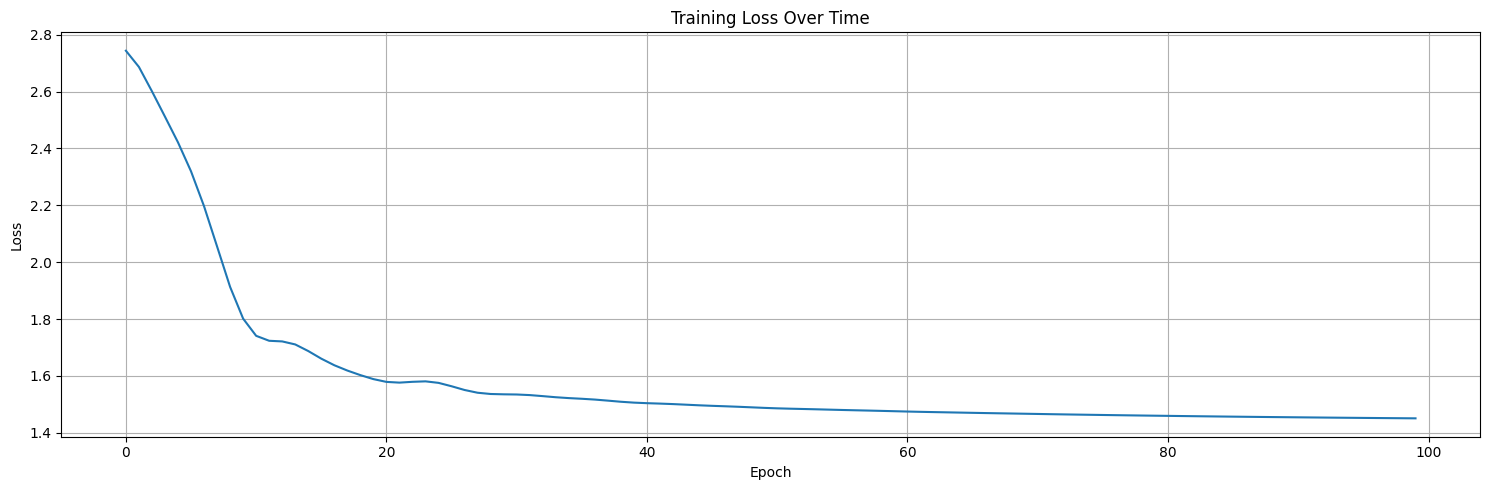

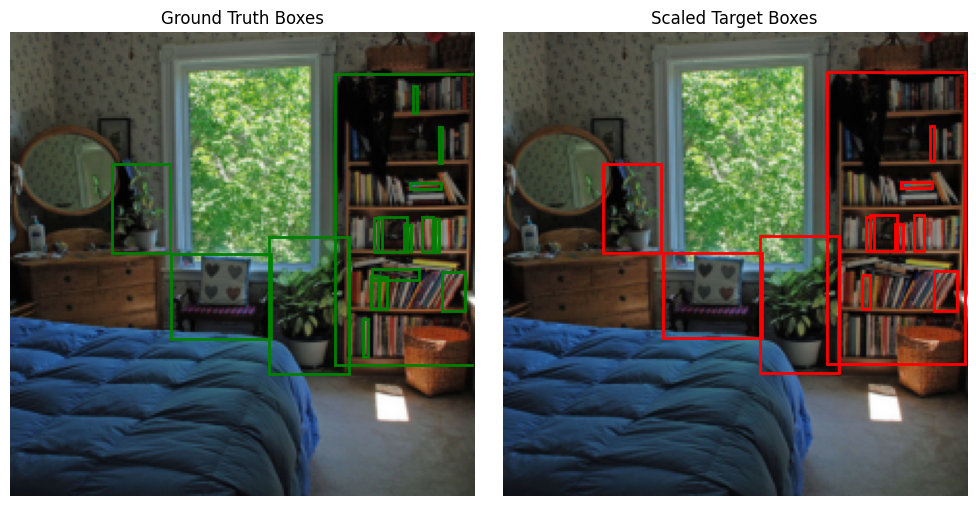

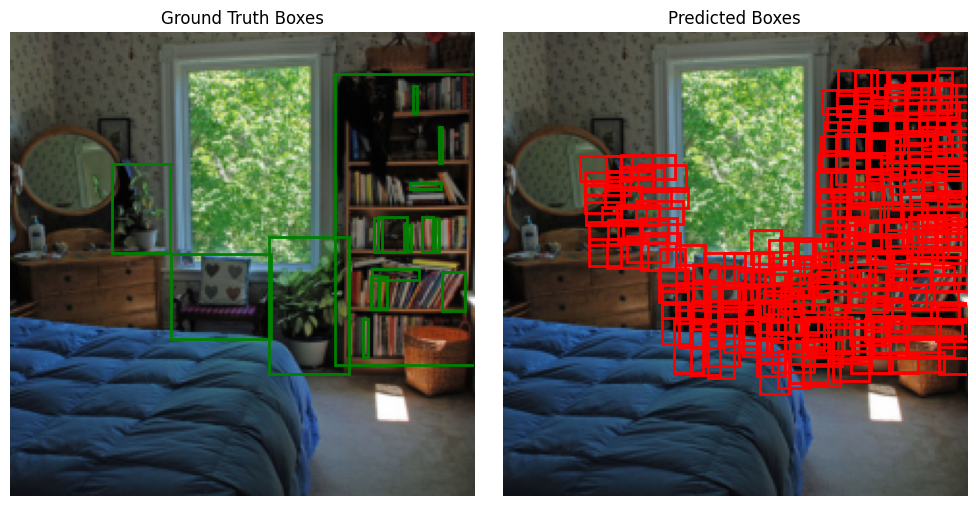

17 4
211 4


In [145]:
# Plot training metrics
plot_training_progress(losses)

# Plot original boxes
plot_boxes(
    final_image,
    original_boxes,
    filtered_input,
    ["g"] * len(original_boxes),
    ["r"] * len(filtered_input),
    "Ground Truth Boxes",
    "Scaled Target Boxes",
)
plot_boxes(
    final_image,
    original_boxes,
    predicted_boxes,
    ["g"] * len(original_boxes),
    ["r"] * len(predicted_boxes),
    "Ground Truth Boxes",
    "Predicted Boxes",
)
print(len(original_boxes), len(original_boxes[0]))
print(len(predicted_boxes), len(predicted_boxes[0]))

The following training code does work but my functions are too inefficient for my resources to handle the training so it always crashes at some point. As the single sample overfitting shows the model mostly works the only issue is the size of the bounding boxes which after countless hours we could not resolve. 

In [146]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data.dataset import Subset
import copy


# Define Dataset class (assuming similar structure as the image input in the provided code)
class COCODataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


dataset = coco

# Split dataset
num_samples = len(dataset)
num_val_samples = int(0.1 * num_samples)
num_train_samples = num_samples - num_val_samples
train_dataset, val_dataset = random_split(dataset, [num_train_samples, num_val_samples])

# DataLoaders
batch_size = 16


def collate_fn(batch):
    images, annotations = zip(*batch)
    images = torch.stack(images, dim=0)

    # Pad annotations (example assumes annotations are lists of dicts)
    max_boxes = max(len(ann) for ann in annotations)
    padded_annotations = []
    for ann in annotations:
        pad = max_boxes - len(ann)
        ann.extend(
            [{"bbox": [0, 0, 0, 0], "category_id": 0, "area": 0}] * pad
        )  # Example padding
        padded_annotations.append(ann)

    return images, padded_annotations


train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)


# Model setup
resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
backbone = ResNetBackbone(resnet)
fpn = FPN(in_channels)
num_classes = 91
model = FCOS(backbone, fpn, num_classes)


# Optimizer and loss functions
learning_rate = 0.01
optimizer = optim.SGD(
    model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001
)


def train_one_epoch(model, train_dataset, optimizer):
    model.train()
    batch_losses = []
    for i, (image, annotations) in enumerate(train_dataset):
        # Prepare input (same as before)
        model_input = image
        if not isinstance(model_input, torch.Tensor):
            model_input = torch.tensor(model_input, dtype=torch.float32)
        if model_input.dtype != torch.float32:
            model_input = model_input.float()
        if len(model_input.shape) == 3:
            model_input = model_input.unsqueeze(0)
        if model_input.shape[1] != 3:
            model_input = model_input.permute(0, 3, 1, 2)

        target_map = preprocess_target(annotations, num_classes=91)
        scaled_map = [scale_target(target_map)]

        # Training loop like in the single sample training
        optimizer.zero_grad()
        outputs = model(model_input)

        outputs["cls_preds"] = [outputs["cls_preds"]]
        outputs["bbox_preds"] = [outputs["bbox_preds"]]
        outputs["centerness_preds"] = [outputs["centerness_preds"]]

        for batch in range(len(outputs["cls_preds"])):
            cls_loss = 0
            reg_loss = 0
            centerness_loss = 0
            N_pos = 0

            for layer in range(len(outputs["cls_preds"][batch])):
                xyxy_map = copy.deepcopy(scaled_map)
                xyxy_map[batch][layer]["bbox"] = ltrb_to_xyxy(
                    xyxy_map[batch][layer]["bbox"]
                )
                xyxy_output = outputs
                xyxy_output["bbox_preds"][batch][layer] = ltrb_to_xyxy(
                    xyxy_output["bbox_preds"][batch][layer]
                )

                for y in range(xyxy_output["cls_preds"][batch][layer].shape[0]):
                    for x in range(xyxy_output["cls_preds"][batch][layer].shape[1]):
                        cls_pred = xyxy_output["cls_preds"][batch][layer][y, x]
                        cls_target = xyxy_map[batch][layer]["class_id"][y, x]
                        cls_loss += focal_loss(cls_pred, cls_target)

                        if cls_target.max() > 0:
                            N_pos += 1
                            box_pred = xyxy_output["bbox_preds"][batch][layer][y, x]
                            box_target = xyxy_map[batch][layer]["bbox"][y, x]
                            iou = compute_iou(box_pred, box_target)
                            reg_loss += 1 - iou

                            center_pred = xyxy_output["centerness_preds"][batch][layer][
                                y, x
                            ]
                            center_target = xyxy_map[batch][layer]["centerness"][
                                y, x
                            ].unsqueeze(0)
                            centerness_loss += F.binary_cross_entropy(
                                center_pred, center_target
                            )

            N_pos = max(N_pos, 1)
            batch_loss = (1 / N_pos) * (cls_loss + reg_loss + centerness_loss)
            print(f"Batch {i} - Loss: {batch_loss:.4f}")
            batch_losses.append(batch_loss)

    total_loss = sum(batch_losses)
    total_loss.backward()
    optimizer.step()

    return total_loss, batch_losses


def evaluate(model, eval_dataset):
    model.eval()
    batch_losses = []
    with torch.no_grad():
        for i, (image, annotations) in enumerate(eval_dataset):
            model_input = image
            if not isinstance(model_input, torch.Tensor):
                model_input = torch.tensor(model_input, dtype=torch.float32)
            if model_input.dtype != torch.float32:
                model_input = model_input.float()
            if len(model_input.shape) == 3:
                model_input = model_input.unsqueeze(0)
            if model_input.shape[1] != 3:
                model_input = model_input.permute(0, 3, 1, 2)

            target_map = preprocess_target(annotations, num_classes=91)
            scaled_map = [scale_target(target_map)]

            optimizer.zero_grad()
            outputs = model(model_input)

            outputs["cls_preds"] = [outputs["cls_preds"]]
            outputs["bbox_preds"] = [outputs["bbox_preds"]]
            outputs["centerness_preds"] = [outputs["centerness_preds"]]

            for batch in range(len(outputs["cls_preds"])):
                cls_loss = 0
                reg_loss = 0
                centerness_loss = 0
                N_pos = 0

                for layer in range(len(outputs["cls_preds"][batch])):
                    xyxy_map = copy.deepcopy(scaled_map)
                    xyxy_map[batch][layer]["bbox"] = ltrb_to_xyxy(
                        xyxy_map[batch][layer]["bbox"]
                    )
                    xyxy_output = outputs
                    xyxy_output["bbox_preds"][batch][layer] = ltrb_to_xyxy(
                        xyxy_output["bbox_preds"][batch][layer]
                    )

                    for y in range(xyxy_output["cls_preds"][batch][layer].shape[0]):
                        for x in range(xyxy_output["cls_preds"][batch][layer].shape[1]):
                            cls_pred = xyxy_output["cls_preds"][batch][layer][y, x]
                            cls_target = xyxy_map[batch][layer]["class_id"][y, x]
                            cls_loss += focal_loss(cls_pred, cls_target)

                            if cls_target.max() > 0:
                                N_pos += 1
                                box_pred = xyxy_output["bbox_preds"][batch][layer][y, x]
                                box_target = xyxy_map[batch][layer]["bbox"][y, x]
                                iou = compute_iou(box_pred, box_target)
                                reg_loss += 1 - iou

                                center_pred = xyxy_output["centerness_preds"][batch][
                                    layer
                                ][y, x]
                                center_target = xyxy_map[batch][layer]["centerness"][
                                    y, x
                                ].unsqueeze(0)
                                centerness_loss += F.binary_cross_entropy(
                                    center_pred, center_target
                                )

                N_pos = max(N_pos, 1)
                batch_loss = (1 / N_pos) * (cls_loss + reg_loss + centerness_loss)
                print(f"Batch {i} - Loss: {batch_loss:.4f}")
                batch_losses.append(batch_loss)

        total_loss = sum(batch_losses)
        total_loss.backward()
        optimizer.step()

        return total_loss, batch_losses


# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    train_loss, batch_losses = train_one_epoch(model, train_dataset, optimizer)
    val_loss = evaluate(model, val_dataset)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
    )

Batch 0 - Loss: 2.7168
Batch 1 - Loss: 2.7536
Batch 2 - Loss: 2.6951
Batch 3 - Loss: 2.7525
Batch 4 - Loss: 2.6711
Batch 5 - Loss: 2.7418
Batch 6 - Loss: 2.5980
Batch 7 - Loss: 2.7443
Batch 8 - Loss: 2.7080
Batch 9 - Loss: 2.7456
Batch 10 - Loss: 2.7325


KeyboardInterrupt: 